# Task 3 : Data Collection in the Wild [4 marks]

## Task Description

For this exercise marks will not depend on what numbers you get but on the process you followed Utilize apps like `Physics Toolbox Suite` from your smartphone to collect your data in .csv/.txt format. Ensure at least 15 seconds of data is collected, trimming edges to obtain 10 seconds of relevant data. Also record a video of yourself while recording data. This video will be required in some future assignments. Collect 3-5 samples per activity class.

### Questions

1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? **[1 marks]**
2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? **[1 marks]**

Firsly after collecting all the data, we preprocess it. We used the gForece meter of the `Physics Toolbox Suite` app to collect the data. However there were some difficulties which we faced when preprocessing the data. The data that was collected was sampled at the highest frequency possible from our mobile. Hence the samples were also not evenly spaced. The sampling frequency kept changing between 190 Hz to 210 Hz. This made it difficult to use the data as it is. So we took a sliding window of 20 miliseconds and calculated the mean of the samples in that window. This way we were able to get evenly spaced samples at a frequency of 50 Hz.

All the preprocessing was done in `./Datasets/task3_data/Asst#3_pipeline.ipynb` notebook. After that we run/train the pretrained/new models on the data which we collected and analyse the results.

## Results for Task 3

| Features Type | Training Data | Testing Data | Accuracy | Precision | Recall |
|---------------|---------------|--------------|----------|-----------|--------|
| Raw accelerometer data      | UCI-HAR       | Custom       | 0.3472      | 0.4476       | 0.3472    |
| TSFEL data (all features)    | UCI-HAR       | Custom       | 0.4791      | 0.5       | 0.479    |
| TSFEL data (filtered features)      | UCI-HAR       | Custom       | 0.791      | 0.8143       | 0.716    |
| Raw accelerometer data | Custom (2 subjects)      | Custom (1 subject)      | 0.625      | 0.6388       | 0.625    |
| TSFEL data (all features)      | Custom (2 subjects)      | Custom (1 subject)     | 0.75      | 0.7407       | 0.75    |
| TSFEL data (filtered features)    | Custom (2 subjects)      | Custom (1 subject)     | 0.66      | 0.674       | 0.66    |

As we can see, when trained on the UCI-HAR dataset, the model performs better on the custom dataset when the features are filtered, with an accuracy of 0.791. 

When trained on the custom dataset, the model performs better when the features are all used, with an accuracy of 0.75.

## Custom data leave-one-out Cross validation results
We did cross validation by leaving one activity per subject out. We trained the model on the remaining activities and tested on the left out activity. We repeated this for all the activities and subjects. The results are as follows:

| Features Type | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| Raw accelerometer data | 0.5417      | 0.4638       | 0.5417    |
| TSFEL data (all features)      | 0.9306      | 0.9455       | 0.9306    |
| TSFEL data (filtered features)      | 0.8750      | 0.8772       | 0.8750    |

Here, we see that the model performs best when trained on the TSFEL data with all features, with an accuracy of 0.9306.




## Importing required libraries

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm
from typing import Union
import re
from langchain_groq.chat_models import ChatGroq
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (classification_report, precision_score, recall_score, accuracy_score, 
                             confusion_matrix)
from HAR.MakeTask3Dataset import X, y

## Utility functions

In [16]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def plot_waveforms(sample_data, titles, plot_title, start):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(22, 4))
    fig.suptitle(plot_title)

    dfs = [pd.read_csv(sample).iloc[start:start+500, :] for sample in sample_data]

    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
        ax.set_title(titles[i])
        ax.set_ylim([-1, 2.2])
        ax.set_xlim([start, start+500])
        ax.plot(dfs[i]['accx'], color='r', label='accx')
        ax.plot(dfs[i]['accy'], color='g', label='accy')
        ax.plot(dfs[i]['accz'], color='b', label='accz')
        ax.legend()
        ax.grid(True)  

    plt.show()

## Visualising the UCI and custom datasets

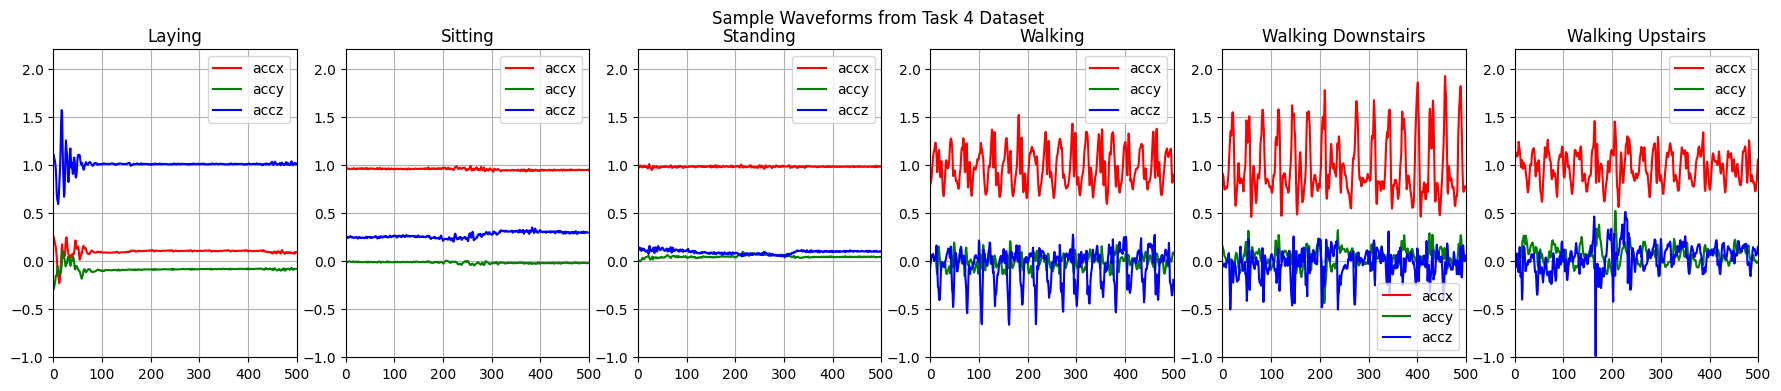

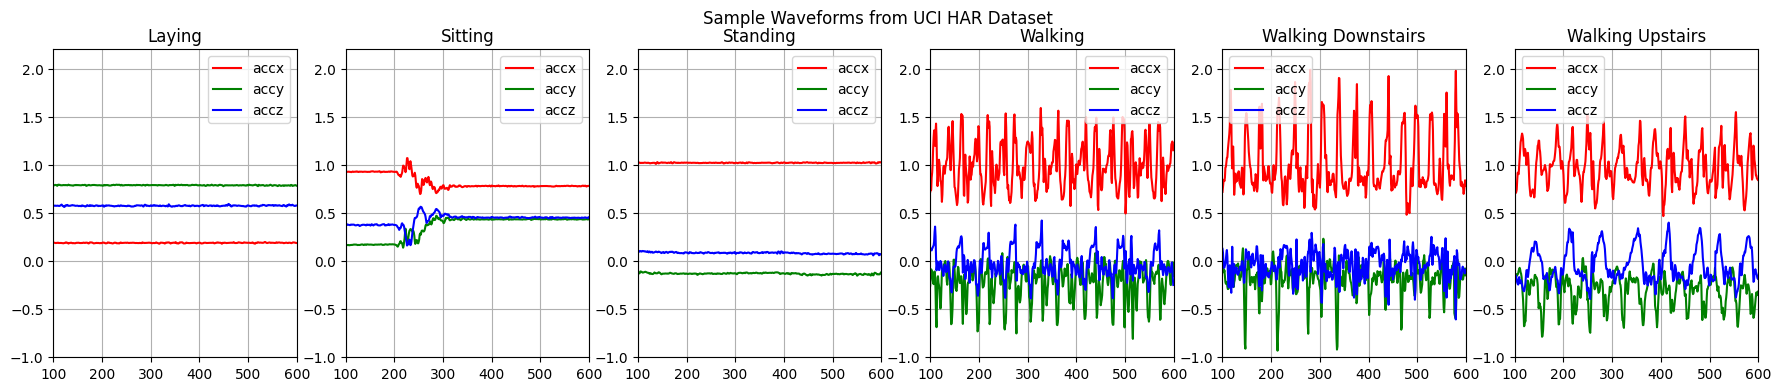

In [17]:
sample_data1 = get_sample_data(os.path.join("Datasets", 'task3_data', 'raw_dataset', 'Train'), 1)
titles1 = [sample.split('\\')[4].title().replace('_', ' ') for sample in sample_data1]
plot_waveforms(sample_data1, titles1, "Sample Waveforms from Task 4 Dataset", 0)

sample_data2 = get_sample_data(os.path.join("Datasets", 'Combined', 'Train'), 1)
titles2 = [sample.split('\\')[3].title().replace('_', ' ') for sample in sample_data2]
plot_waveforms(sample_data2, titles2, "Sample Waveforms from UCI HAR Dataset", 100)


## 1. Using the pretrained Decision tree to classify recorded activities

We took 2 pretrained Decision trees:
1. The one that is trained on the raw accelerometer data.
2. The one that is trained on the featurised TSFEL data.

We evaluated the accuracy in predicting the 

### Training on UCI HAR raw data, testing on custom data

In [18]:
from HAR.MakeDataset import X_train, y_train
from HAR.MakeTask3Dataset import X as X_test, y as y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (72, 500, 3)
y_train shape: (126,)
y_test shape: (72,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (72, 1500)


In [19]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [20]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.29      0.17      0.21        12
  WALKING_UPSTAIRS       0.00      0.00      0.00        12
WALKING_DOWNSTAIRS       0.33      0.58      0.42        12
           SITTING       0.07      0.17      0.10        12
          STANDING       1.00      0.17      0.29        12
            LAYING       1.00      1.00      1.00        12

          accuracy                           0.35        72
         macro avg       0.45      0.35      0.34        72
      weighted avg       0.45      0.35      0.34        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2857, Recall = 0.1667, Accuracy = 0.7917
Class WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
Class WALKING_DOWNSTAIRS: Precision = 0.3333, Recall = 0.5833, Accuracy = 0.7361
Class SITTING: Precision = 0.0667, Recall = 0.1667, Accuracy = 0.4722
Class STANDING: Precision

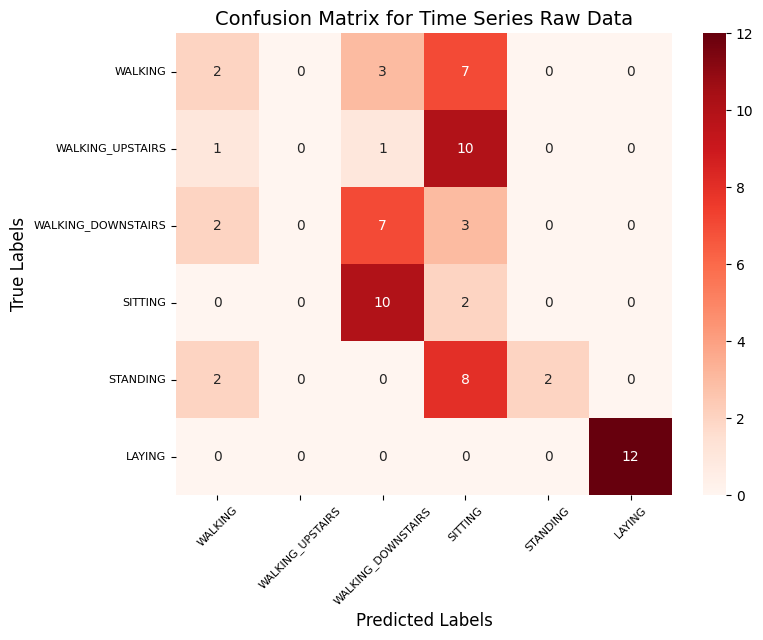

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


### Training on all 1173 UCI HAR TSFEL features, testing on custom data

In [22]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

In [23]:

base_dir1 = 'Datasets/TSFEL_3axes_allfeatures'  
base_dir2 = 'Datasets/task3_data/TSFEL_dataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")



X_train shape: (126, 1, 1173)
y_train shape: (126,)
X_test shape: (48, 1, 1173)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)
X_train shape: (126, 1, 1173)
X_test shape: (48, 1, 1173)
y_train shape: (126,)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)


In [24]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}"
      )
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         8
  WALKING_UPSTAIRS       0.00      0.00      0.00         8
WALKING_DOWNSTAIRS       0.42      0.62      0.50         8
           SITTING       0.50      1.00      0.67         8
          STANDING       0.86      0.75      0.80         8
            LAYING       0.50      0.12      0.20         8

          accuracy                           0.58        48
         macro avg       0.55      0.58      0.53        48
      weighted avg       0.55      0.58      0.53        48

Precision, Recall, and Accuracy for each

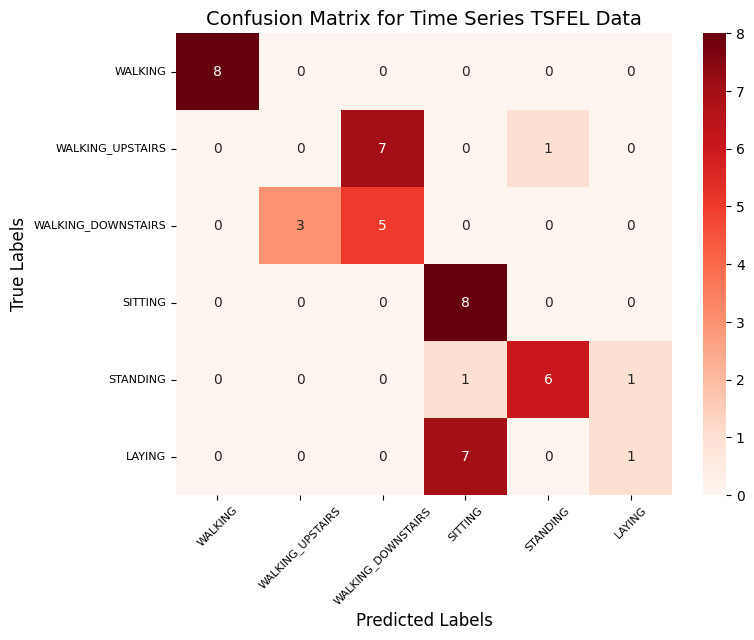

In [25]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series TSFEL Data', fontsize=14)

plt.show()

### Training on filtered 60 UCI HAR TSFEL features, testing on custom data

In [54]:

base_dir1 = 'Datasets/TSFEL_3axes_filteredfeatures'  
base_dir2 = 'Datasets/task3_data/TSFEL_filtereddataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")



X_train shape: (126, 1, 60)
y_train shape: (126,)
X_test shape: (48, 1, 60)
y_test shape: (48,)
X_train_flat shape: (126, 60)
X_test_flat shape: (48, 60)
X_train shape: (126, 1, 60)
X_test shape: (48, 1, 60)
y_train shape: (126,)
y_test shape: (48,)
X_train_flat shape: (126, 60)
X_test_flat shape: (48, 60)


In [55]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         8
  WALKING_UPSTAIRS       0.70      0.88      0.78         8
WALKING_DOWNSTAIRS       1.00      0.62      0.77         8
           SITTING       0.80      1.00      0.89         8
          STANDING       0.64      0.88      0.74         8
            LAYING       0.75      0.38      0.50         8

          accuracy                           0.79        48
         macro avg       0.81      0.79      0.78        48
      weighted avg       0.81      0.79      0.78        48

Precision, Recall, and Accuracy for each

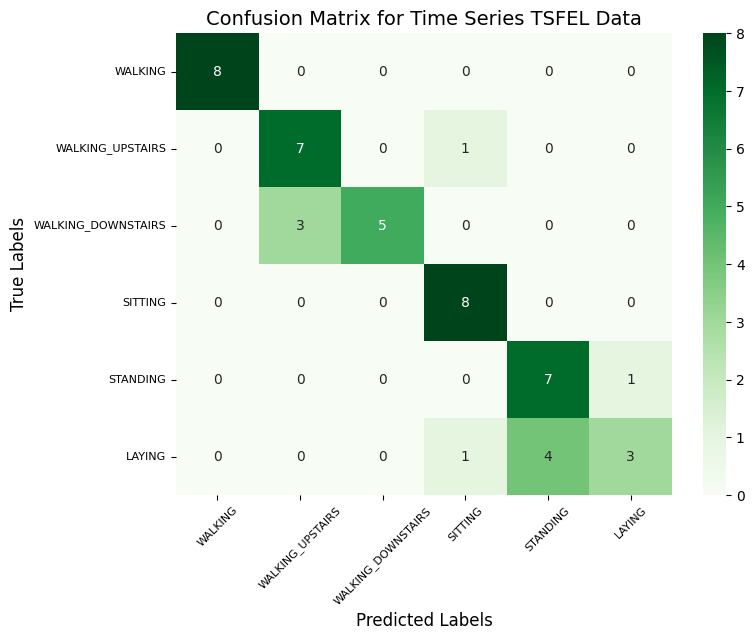

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series TSFEL Data', fontsize=14)

plt.show()

## 2. Training on Collected data

### In this part first 2 subjects are of the custom dataset, testing on the third subject of custom dataset

In [57]:
from MakeTask4Dataset import X_train, y_train, X_test, y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


X_train shape: (48, 500, 3)
X_test shape: (24, 500, 3)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1500)
X_test_flat shape: (24, 1500)


In [58]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.33      0.50      0.40         4
  WALKING_UPSTAIRS       0.50      0.25      0.33         4
WALKING_DOWNSTAIRS       0.75      0.75      0.75         4
           SITTING       0.25      0.25      0.25         4
          STANDING       1.00      1.00      1.00         4
            LAYING       1.00      1.00      1.00         4

          accuracy                           0.62        24
         macro avg       0.64      0.62      0.62        24
      weighted avg       0.64      0.62      0.62        24

Precision, Recall, and Accuracy for each

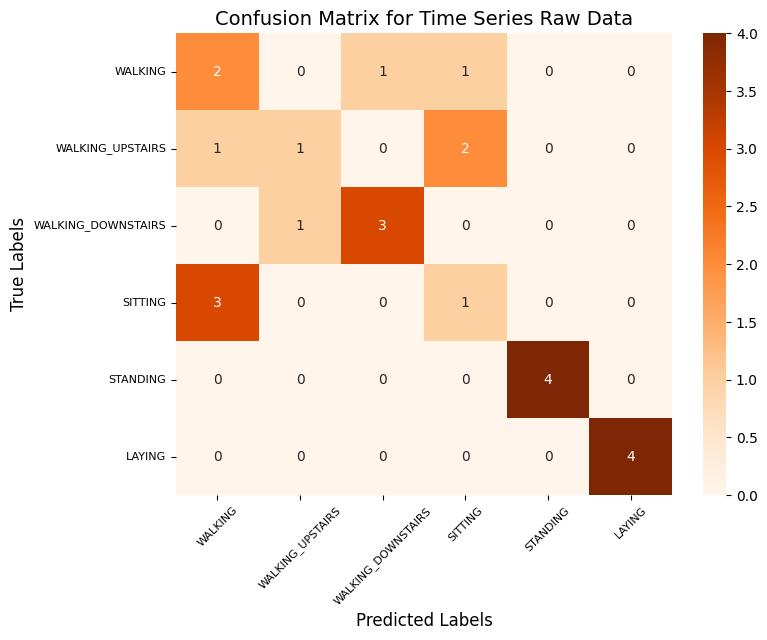

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()

### Training on all 1173 features of TSFEL data
In this part first 2 subjects of custom dataset, testing on the third subject of custom dataset

In [60]:
base_dir = 'Datasets/task3_data/TSFEL_dataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (48, 1, 1173)
y_train shape: (48,)
X_test shape: (24, 1, 1173)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)
X_train shape: (48, 1, 1173)
X_test shape: (24, 1, 1173)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)


In [33]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         4
  WALKING_UPSTAIRS       1.00      1.00      1.00         4
WALKING_DOWNSTAIRS       1.00      1.00      1.00         4
           SITTING       1.00      0.50      0.67         4
          STANDING       0.00      0.00      0.00         4
            LAYING       0.44      1.00      0.62         4

          accuracy                           0.75        24
         macro avg       0.74      0.75      0.71        24
      weighted avg       0.74      0.75      0.71        24

Precision, Recall, and Accuracy for each

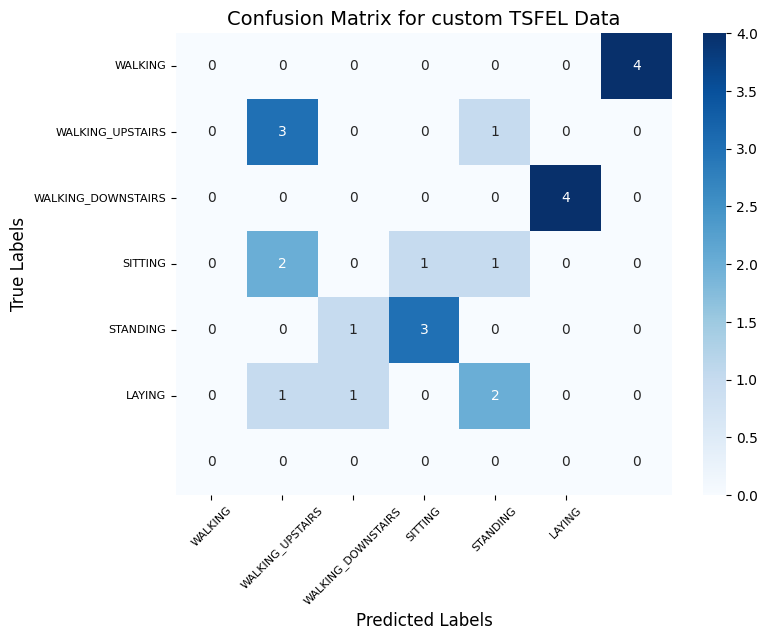

In [61]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for custom TSFEL Data', fontsize=14)

plt.show()

### Training on filtered TSFEL data
In this part first 2 subjects of custom dataset, testing on the third subject of custom dataset

In [62]:
base_dir = 'Datasets/task3_data/TSFEL_filtereddataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (48, 1, 60)
y_train shape: (48,)
X_test shape: (24, 1, 60)
y_test shape: (24,)
X_train_flat shape: (48, 60)
X_test_flat shape: (24, 60)
X_train shape: (48, 1, 60)
X_test shape: (24, 1, 60)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 60)
X_test_flat shape: (24, 60)


In [63]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         4
  WALKING_UPSTAIRS       0.80      1.00      0.89         4
WALKING_DOWNSTAIRS       1.00      0.75      0.86         4
           SITTING       0.75      0.75      0.75         4
          STANDING       0.25      0.25      0.25         4
            LAYING       0.25      0.25      0.25         4

          accuracy                           0.67        24
         macro avg       0.67      0.67      0.67        24
      weighted avg       0.67      0.67      0.67        24

Precision, Recall, and Accuracy for each

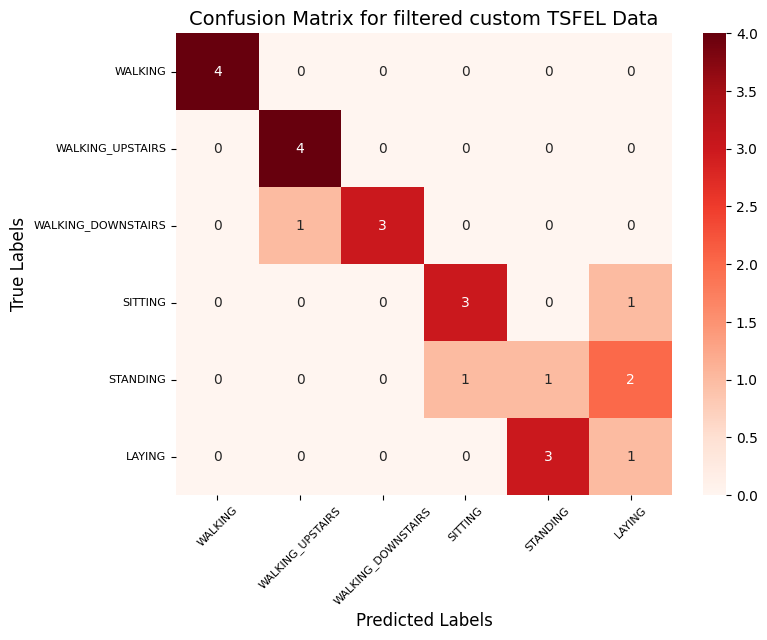

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for filtered custom TSFEL Data', fontsize=14)

plt.show()

## Cross validation on collected data

### Leave one out cross validation on raw custom data

In [65]:
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

X_flat = X.reshape(X.shape[0], -1)

loo = LeaveOneOut()

y_true_all = []
y_pred_all = []

for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)


In [66]:

print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00        12
  WALKING_UPSTAIRS       0.83      0.83      0.83        12
WALKING_DOWNSTAIRS       0.92      0.92      0.92        12
           SITTING       0.79      0.92      0.85        12
          STANDING       0.91      0.83      0.87        12
            LAYING       0.82      0.75      0.78        12

          accuracy                           0.88        72
         macro avg       0.88      0.88      0.87        72
      weighted avg       0.88      0.88      0.87        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.9444
Class WALKING_UPSTAIRS: Precision = 0.8333, Recall = 0.8333, Accuracy = 0.9722
Class WALKING_DOWNSTAIRS: Precision = 0.9167, Recall = 0.9167, Accuracy = 0.9444
Class SITTING: Precision = 0.7857, Recall = 0.9167, Accuracy = 0.9583
Class STANDING: Precision

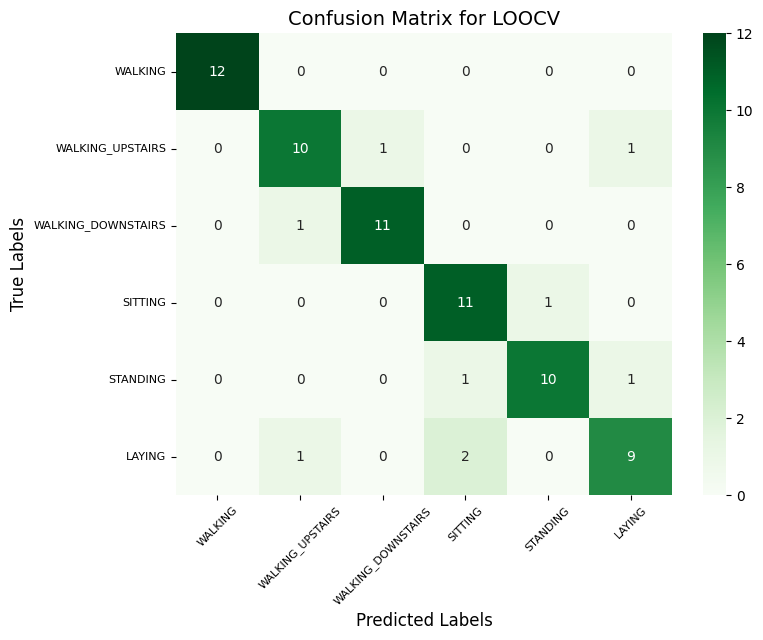

In [68]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV', fontsize=14)

plt.show()

### Leave one out cross validation on complete TSFEL featurized custom dataset

In [69]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, precision_score, recall_score, accuracy_score, 
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from MakeTask4Dataset import X, y
base_dir = 'Datasets/task3_data/TSFEL_dataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')
# Concatenate the training and testing data
X = np.concatenate((X_train, X_test), axis=0)  # Concatenate along the first axis (rows)
y = np.concatenate((y_train, y_test), axis=0)  # Concatenate along the first axis (rows)

# Print shapes to verify
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
# Dictionary to map class labels to activity names
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

# Flatten the data
X_flat = X.reshape(X.shape[0], -1)

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialize lists to store true labels and predictions
y_true_all = []
y_pred_all = []

# Perform Leave-One-Out Cross-Validation
for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Store the true labels and predictions
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

X shape: (72, 1, 1173)
y shape: (72,)


In [70]:
# Print classification report
print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

# Calculate precision, recall, and accuracy for each class
precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

# Calculate overall precision, recall, and accuracy
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      0.92      0.96        12
  WALKING_UPSTAIRS       1.00      0.83      0.91        12
WALKING_DOWNSTAIRS       1.00      0.92      0.96        12
           SITTING       1.00      0.92      0.96        12
          STANDING       0.92      1.00      0.96        12
            LAYING       0.75      1.00      0.86        12

          accuracy                           0.93        72
         macro avg       0.95      0.93      0.93        72
      weighted avg       0.95      0.93      0.93        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9722
Class WALKING_UPSTAIRS: Precision = 1.0000, Recall = 0.8333, Accuracy = 0.9861
Class WALKING_DOWNSTAIRS: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9861
Class SITTING: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9861
Class STANDING: Precision

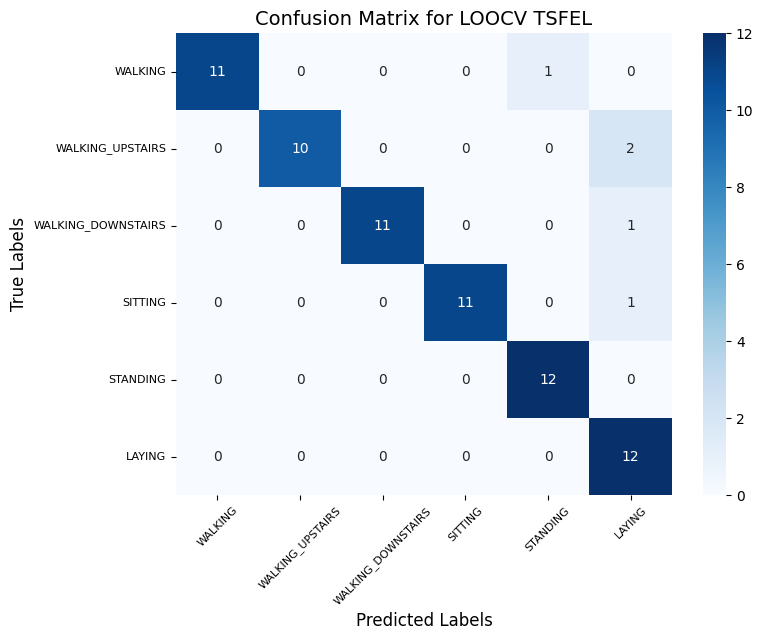

In [71]:

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV TSFEL', fontsize=14)

plt.show()

### Leave one out cross validation on filtered TSFEL featurized custom dataset

In [72]:
base_dir = 'Datasets/task3_data/TSFEL_filtereddataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

X = np.concatenate((X_train, X_test), axis=0)  # Concatenate along the first axis (rows)
y = np.concatenate((y_train, y_test), axis=0)  # Concatenate along the first axis (rows)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

X_flat = X.reshape(X.shape[0], -1)

loo = LeaveOneOut()

y_true_all = []
y_pred_all = []

for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

X shape: (72, 1, 60)
y shape: (72,)


In [73]:
print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00        12
  WALKING_UPSTAIRS       0.83      0.83      0.83        12
WALKING_DOWNSTAIRS       0.92      0.92      0.92        12
           SITTING       0.79      0.92      0.85        12
          STANDING       0.91      0.83      0.87        12
            LAYING       0.82      0.75      0.78        12

          accuracy                           0.88        72
         macro avg       0.88      0.88      0.87        72
      weighted avg       0.88      0.88      0.87        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.9444
Class WALKING_UPSTAIRS: Precision = 0.8333, Recall = 0.8333, Accuracy = 0.9722
Class WALKING_DOWNSTAIRS: Precision = 0.9167, Recall = 0.9167, Accuracy = 0.9444
Class SITTING: Precision = 0.7857, Recall = 0.9167, Accuracy = 0.9583
Class STANDING: Precision

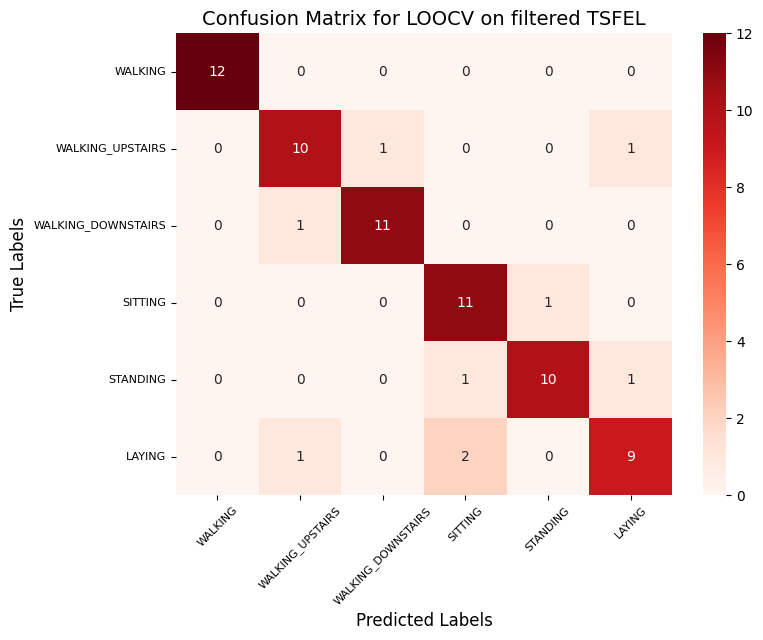

In [74]:

conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV on filtered TSFEL', fontsize=14)

plt.show()